# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Tue Jun  3 18:27:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P5             18W /   80W |    2845MiB /   6144MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGenerator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [4]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/standard_model_bce_copy",
    checkpoints_dir="../checkpoints/standard_model_bce_copy",
    batch_size=4,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="standard",  # Koristimo standardnu arhitekturu
    sample_interval=10,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: standard
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 4
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    discriminator_update_freq=1,
    loss_type='BCE'
)

Epoha 1/150: 100%|██████████| 115/115 [00:34<00:00,  3.36it/s, D_A=0.6878, D_B=0.7003, G=3.1894]


Epoha 1/150 - Train gubici: G: 6.6412, D_A: 0.6480, D_B: 0.5711 | Val gubici: G: 2.7293, Cycle: 1.7221
Novi najbolji validacijski cycle gubitak: 1.7221, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.7293, spremam modele...


Epoha 2/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.6427, D_B=0.5059, G=2.9686]


Epoha 2/150 - Train gubici: G: 3.0860, D_A: 0.6607, D_B: 0.6334 | Val gubici: G: 2.5335, Cycle: 1.1873
Novi najbolji validacijski cycle gubitak: 1.1873, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.5335, spremam modele...


Epoha 3/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.6438, D_B=0.3244, G=3.6479]


Epoha 3/150 - Train gubici: G: 2.9902, D_A: 0.6632, D_B: 0.6094 | Val gubici: G: 2.5686, Cycle: 1.1873
Novi najbolji validacijski cycle gubitak: 1.1873, spremam modele...


Epoha 4/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.7691, D_B=0.2649, G=2.5859]


Epoha 4/150 - Train gubici: G: 2.9058, D_A: 0.6629, D_B: 0.5478 | Val gubici: G: 2.5726, Cycle: 1.0214
Novi najbolji validacijski cycle gubitak: 1.0214, spremam modele...


Epoha 5/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.6257, D_B=0.5380, G=2.9721]


Epoha 5/150 - Train gubici: G: 2.8784, D_A: 0.6415, D_B: 0.5301 | Val gubici: G: 2.4502, Cycle: 0.8635
Novi najbolji validacijski cycle gubitak: 0.8635, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.4502, spremam modele...


Epoha 6/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.6426, D_B=0.7948, G=3.2960]


Epoha 6/150 - Train gubici: G: 3.1836, D_A: 0.6478, D_B: 0.4387 | Val gubici: G: 3.4180, Cycle: 0.8145
Novi najbolji validacijski cycle gubitak: 0.8145, spremam modele...


Epoha 7/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.5820, D_B=0.2169, G=2.6536]


Epoha 7/150 - Train gubici: G: 3.0277, D_A: 0.6462, D_B: 0.4457 | Val gubici: G: 1.8470, Cycle: 0.8727
Novi najbolji validacijski GAN gubitak: 1.8470, spremam modele...


Epoha 8/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.6994, D_B=0.5542, G=2.8183]


Epoha 8/150 - Train gubici: G: 3.0758, D_A: 0.6403, D_B: 0.4090 | Val gubici: G: 4.0008, Cycle: 0.8478


Epoha 9/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.6821, D_B=0.2334, G=2.9218]


Epoha 9/150 - Train gubici: G: 3.2544, D_A: 0.6492, D_B: 0.3513 | Val gubici: G: 1.9304, Cycle: 0.7958
Novi najbolji validacijski cycle gubitak: 0.7958, spremam modele...


Epoha 10/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.4719, D_B=0.4232, G=2.9680]


Epoha 10/150 - Train gubici: G: 2.9742, D_A: 0.6049, D_B: 0.4229 | Val gubici: G: 2.3960, Cycle: 0.9118


Epoha 11/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.8731, D_B=0.1789, G=3.4502]


Epoha 11/150 - Train gubici: G: 3.0917, D_A: 0.6034, D_B: 0.3995 | Val gubici: G: 2.6583, Cycle: 0.8753


Epoha 12/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.6533, D_B=0.2829, G=3.4720]


Epoha 12/150 - Train gubici: G: 2.9495, D_A: 0.6004, D_B: 0.3886 | Val gubici: G: 1.7699, Cycle: 0.9033
Novi najbolji validacijski GAN gubitak: 1.7699, spremam modele...


Epoha 13/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.4006, D_B=0.6244, G=3.0707]


Epoha 13/150 - Train gubici: G: 3.0865, D_A: 0.6201, D_B: 0.4157 | Val gubici: G: 4.0712, Cycle: 0.9773


Epoha 14/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.2268, D_B=0.4038, G=3.3541]


Epoha 14/150 - Train gubici: G: 3.1482, D_A: 0.5585, D_B: 0.4199 | Val gubici: G: 3.3765, Cycle: 1.1710


Epoha 15/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.3599, D_B=0.2012, G=2.9883]


Epoha 15/150 - Train gubici: G: 3.3635, D_A: 0.4750, D_B: 0.4062 | Val gubici: G: 2.3960, Cycle: 0.8974


Epoha 16/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.6146, D_B=0.6035, G=2.3513]


Epoha 16/150 - Train gubici: G: 3.1115, D_A: 0.5636, D_B: 0.4400 | Val gubici: G: 4.5178, Cycle: 0.8010


Epoha 17/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.4274, D_B=0.2754, G=3.4216]


Epoha 17/150 - Train gubici: G: 3.0592, D_A: 0.5152, D_B: 0.3948 | Val gubici: G: 4.1207, Cycle: 0.9377


Epoha 18/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.4248, D_B=0.2596, G=4.2005]


Epoha 18/150 - Train gubici: G: 3.1774, D_A: 0.5089, D_B: 0.4383 | Val gubici: G: 2.1221, Cycle: 0.9086


Epoha 19/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.4570, D_B=1.1948, G=2.6899]


Epoha 19/150 - Train gubici: G: 3.1775, D_A: 0.4998, D_B: 0.4270 | Val gubici: G: 5.1397, Cycle: 0.8214


Epoha 20/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.4961, D_B=0.3626, G=2.4670]


Epoha 20/150 - Train gubici: G: 3.1396, D_A: 0.4818, D_B: 0.3955 | Val gubici: G: 4.2083, Cycle: 0.9853


Epoha 21/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.2709, D_B=0.2223, G=3.5644]


Epoha 21/150 - Train gubici: G: 3.2289, D_A: 0.4982, D_B: 0.3933 | Val gubici: G: 2.8132, Cycle: 0.9073


Epoha 22/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.3109, D_B=0.3949, G=3.3931]


Epoha 22/150 - Train gubici: G: 3.2727, D_A: 0.4745, D_B: 0.4050 | Val gubici: G: 2.8141, Cycle: 0.8695


Epoha 23/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.4316, D_B=0.4116, G=2.8133]


Epoha 23/150 - Train gubici: G: 3.1678, D_A: 0.4706, D_B: 0.4149 | Val gubici: G: 3.4338, Cycle: 0.8588


Epoha 24/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.2231, D_B=0.4903, G=3.2802]


Epoha 24/150 - Train gubici: G: 3.1570, D_A: 0.4559, D_B: 0.3934 | Val gubici: G: 3.1483, Cycle: 1.1931


Epoha 25/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.7988, D_B=0.2388, G=2.2657]


Epoha 25/150 - Train gubici: G: 3.3329, D_A: 0.4397, D_B: 0.3639 | Val gubici: G: 4.4356, Cycle: 1.0322


Epoha 26/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.2355, D_B=0.4856, G=3.1517]


Epoha 26/150 - Train gubici: G: 3.2891, D_A: 0.4546, D_B: 0.4112 | Val gubici: G: 3.7242, Cycle: 1.0003


Epoha 27/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.2104, D_B=0.3774, G=3.2039]


Epoha 27/150 - Train gubici: G: 3.1933, D_A: 0.4595, D_B: 0.3983 | Val gubici: G: 2.9420, Cycle: 0.9347


Epoha 28/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.2658, D_B=0.1959, G=1.6048]


Epoha 28/150 - Train gubici: G: 3.2232, D_A: 0.4595, D_B: 0.3852 | Val gubici: G: 1.6765, Cycle: 0.9006
Novi najbolji validacijski GAN gubitak: 1.6765, spremam modele...


Epoha 29/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.3119, D_B=0.4835, G=3.7608]


Epoha 29/150 - Train gubici: G: 3.3052, D_A: 0.4402, D_B: 0.4138 | Val gubici: G: 2.1602, Cycle: 0.9694


Epoha 30/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.5312, D_B=0.7204, G=2.9090]


Epoha 30/150 - Train gubici: G: 3.2163, D_A: 0.4554, D_B: 0.3906 | Val gubici: G: 2.3602, Cycle: 0.8945


Epoha 31/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2128, D_B=0.0890, G=2.5237]


Epoha 31/150 - Train gubici: G: 3.3738, D_A: 0.4359, D_B: 0.4005 | Val gubici: G: 1.7653, Cycle: 0.9442


Epoha 32/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.1615, D_B=0.1716, G=3.1884]


Epoha 32/150 - Train gubici: G: 3.2927, D_A: 0.4377, D_B: 0.3821 | Val gubici: G: 2.0570, Cycle: 0.8343


Epoha 33/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.6803, D_B=0.6684, G=2.5643]


Epoha 33/150 - Train gubici: G: 3.1822, D_A: 0.4576, D_B: 0.4143 | Val gubici: G: 4.8505, Cycle: 1.0489


Epoha 34/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.4119, D_B=0.0776, G=2.9928]


Epoha 34/150 - Train gubici: G: 3.2335, D_A: 0.4384, D_B: 0.3641 | Val gubici: G: 3.8068, Cycle: 0.9378


Epoha 35/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.4721, D_B=0.4919, G=3.2378]


Epoha 35/150 - Train gubici: G: 3.2534, D_A: 0.4441, D_B: 0.3647 | Val gubici: G: 4.6525, Cycle: 1.1953


Epoha 36/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.5591, D_B=0.5300, G=2.6248]


Epoha 36/150 - Train gubici: G: 3.2571, D_A: 0.4425, D_B: 0.6828 | Val gubici: G: 3.6336, Cycle: 0.9717


Epoha 37/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.1044, D_B=0.3683, G=3.1712]


Epoha 37/150 - Train gubici: G: 3.0734, D_A: 0.4375, D_B: 0.4062 | Val gubici: G: 2.9506, Cycle: 0.8560


Epoha 38/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.3427, D_B=0.2464, G=3.6788]


Epoha 38/150 - Train gubici: G: 3.0941, D_A: 0.4394, D_B: 0.3966 | Val gubici: G: 2.5923, Cycle: 0.9484


Epoha 39/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=1.0963, D_B=0.3888, G=2.3020]


Epoha 39/150 - Train gubici: G: 3.1874, D_A: 0.3934, D_B: 0.3771 | Val gubici: G: 3.6794, Cycle: 0.9485


Epoha 40/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.1360, D_B=0.1255, G=1.8022]


Epoha 40/150 - Train gubici: G: 3.3822, D_A: 0.4028, D_B: 0.3805 | Val gubici: G: 1.4108, Cycle: 0.9587
Novi najbolji validacijski GAN gubitak: 1.4108, spremam modele...


Epoha 41/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.4544, D_B=0.2450, G=3.5822]


Epoha 41/150 - Train gubici: G: 3.3179, D_A: 0.4198, D_B: 0.3636 | Val gubici: G: 6.0282, Cycle: 0.9423


Epoha 42/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1169, D_B=0.4305, G=2.8390]


Epoha 42/150 - Train gubici: G: 3.5112, D_A: 0.3741, D_B: 0.3704 | Val gubici: G: 3.8485, Cycle: 0.9548


Epoha 43/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.4874, D_B=0.2250, G=3.5864]


Epoha 43/150 - Train gubici: G: 3.4883, D_A: 0.4474, D_B: 0.4338 | Val gubici: G: 1.7969, Cycle: 0.9182


Epoha 44/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1686, D_B=0.1006, G=2.5257]


Epoha 44/150 - Train gubici: G: 3.0821, D_A: 0.4330, D_B: 0.3669 | Val gubici: G: 1.6602, Cycle: 0.9506


Epoha 45/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2624, D_B=0.4340, G=3.3861]


Epoha 45/150 - Train gubici: G: 3.2686, D_A: 0.4181, D_B: 0.3666 | Val gubici: G: 1.8548, Cycle: 0.8842


Epoha 46/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.5583, D_B=0.1650, G=3.3236]


Epoha 46/150 - Train gubici: G: 3.4152, D_A: 0.4009, D_B: 0.3387 | Val gubici: G: 2.9212, Cycle: 1.0548


Epoha 47/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2346, D_B=0.2791, G=3.1529]


Epoha 47/150 - Train gubici: G: 3.4763, D_A: 0.4596, D_B: 0.3502 | Val gubici: G: 2.1709, Cycle: 0.9843


Epoha 48/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1832, D_B=0.2930, G=3.3640]


Epoha 48/150 - Train gubici: G: 3.3485, D_A: 0.3949, D_B: 0.3603 | Val gubici: G: 3.9340, Cycle: 0.8945


Epoha 49/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.4710, D_B=0.1192, G=2.8600]


Epoha 49/150 - Train gubici: G: 3.4740, D_A: 0.3801, D_B: 0.3277 | Val gubici: G: 3.2730, Cycle: 0.9345


Epoha 50/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.6949, D_B=2.3533, G=3.1253] 


Epoha 50/150 - Train gubici: G: 3.8498, D_A: 0.3832, D_B: 0.6576 | Val gubici: G: 6.5016, Cycle: 1.1513


Epoha 51/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.3684, D_B=0.5360, G=3.4716]


Epoha 51/150 - Train gubici: G: 2.9932, D_A: 0.3859, D_B: 0.6313 | Val gubici: G: 2.2186, Cycle: 0.9187


Epoha 52/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.3664, D_B=0.4324, G=3.6756]


Epoha 52/150 - Train gubici: G: 3.1812, D_A: 0.3727, D_B: 0.4626 | Val gubici: G: 3.4961, Cycle: 1.0278


Epoha 53/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.7870, D_B=0.4460, G=3.7323]


Epoha 53/150 - Train gubici: G: 3.1506, D_A: 0.4264, D_B: 0.4082 | Val gubici: G: 3.3220, Cycle: 1.0887


Epoha 54/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1812, D_B=0.5667, G=3.7323]


Epoha 54/150 - Train gubici: G: 3.3337, D_A: 0.3735, D_B: 0.3727 | Val gubici: G: 1.8126, Cycle: 0.9222


Epoha 55/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2156, D_B=0.2149, G=4.1123]


Epoha 55/150 - Train gubici: G: 3.4172, D_A: 0.3489, D_B: 0.3780 | Val gubici: G: 3.8968, Cycle: 0.9748


Epoha 56/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.8121, D_B=0.2438, G=3.3346]


Epoha 56/150 - Train gubici: G: 3.3946, D_A: 0.4039, D_B: 0.3737 | Val gubici: G: 2.4039, Cycle: 0.9797


Epoha 57/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.7352, D_B=0.3843, G=2.9684]


Epoha 57/150 - Train gubici: G: 3.4056, D_A: 0.3783, D_B: 0.3712 | Val gubici: G: 4.0842, Cycle: 0.9330


Epoha 58/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.3755, D_B=0.2761, G=2.7396]


Epoha 58/150 - Train gubici: G: 3.4116, D_A: 0.3635, D_B: 0.3586 | Val gubici: G: 3.2783, Cycle: 0.9757


Epoha 59/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.5606, D_B=0.4869, G=3.3262]


Epoha 59/150 - Train gubici: G: 3.5299, D_A: 0.3627, D_B: 0.4916 | Val gubici: G: 3.9537, Cycle: 0.9202


Epoha 60/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.3015, D_B=0.3606, G=3.4372]


Epoha 60/150 - Train gubici: G: 3.3925, D_A: 0.3814, D_B: 0.3649 | Val gubici: G: 4.1432, Cycle: 0.8618


Epoha 61/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.5815, D_B=0.1285, G=3.4131]


Epoha 61/150 - Train gubici: G: 3.4636, D_A: 0.3634, D_B: 0.3399 | Val gubici: G: 5.6051, Cycle: 1.0303


Epoha 62/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1181, D_B=0.3666, G=2.5808]


Epoha 62/150 - Train gubici: G: 3.5928, D_A: 0.3674, D_B: 0.3527 | Val gubici: G: 1.9768, Cycle: 0.8892


Epoha 63/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1983, D_B=0.6445, G=3.8041]


Epoha 63/150 - Train gubici: G: 3.7417, D_A: 0.3062, D_B: 0.3243 | Val gubici: G: 5.3520, Cycle: 0.9246


Epoha 64/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.8816, D_B=0.7269, G=2.1411]


Epoha 64/150 - Train gubici: G: 3.7662, D_A: 0.3487, D_B: 0.3092 | Val gubici: G: 5.4311, Cycle: 1.0244


Epoha 65/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1100, D_B=0.6082, G=3.6269]


Epoha 65/150 - Train gubici: G: 3.6702, D_A: 0.3802, D_B: 0.3228 | Val gubici: G: 6.0379, Cycle: 0.9651


Epoha 66/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.0998, D_B=0.2434, G=2.1775]


Epoha 66/150 - Train gubici: G: 3.5780, D_A: 0.3527, D_B: 0.3169 | Val gubici: G: 2.2383, Cycle: 0.9246


Epoha 67/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.4182, D_B=0.3648, G=3.8950]


Epoha 67/150 - Train gubici: G: 3.5512, D_A: 0.3638, D_B: 0.3164 | Val gubici: G: 4.6655, Cycle: 0.9325


Epoha 68/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.4810, D_B=0.4599, G=3.7304]


Epoha 68/150 - Train gubici: G: 3.5366, D_A: 0.3300, D_B: 0.3003 | Val gubici: G: 3.7999, Cycle: 0.9673


Epoha 69/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1788, D_B=0.1349, G=3.9215]


Epoha 69/150 - Train gubici: G: 3.6392, D_A: 0.3532, D_B: 0.3249 | Val gubici: G: 4.3041, Cycle: 0.8651


Epoha 70/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1226, D_B=0.2839, G=3.4711]


Epoha 70/150 - Train gubici: G: 3.8222, D_A: 0.3062, D_B: 0.3008 | Val gubici: G: 3.7267, Cycle: 0.9484


Epoha 71/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.6117, D_B=0.2944, G=3.4452]


Epoha 71/150 - Train gubici: G: 3.8847, D_A: 0.2951, D_B: 0.2844 | Val gubici: G: 8.1174, Cycle: 0.9536


Epoha 72/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2152, D_B=0.2808, G=3.2970]


Epoha 72/150 - Train gubici: G: 3.8865, D_A: 0.3333, D_B: 0.3124 | Val gubici: G: 2.2847, Cycle: 0.9164


Epoha 73/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2120, D_B=0.0902, G=4.8472]


Epoha 73/150 - Train gubici: G: 3.9285, D_A: 0.3017, D_B: 0.2761 | Val gubici: G: 4.5485, Cycle: 1.1224


Epoha 74/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1366, D_B=0.3873, G=3.1560]


Epoha 74/150 - Train gubici: G: 3.8831, D_A: 0.3136, D_B: 0.2887 | Val gubici: G: 2.3067, Cycle: 1.0081


Epoha 75/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1981, D_B=0.0757, G=4.4718]


Epoha 75/150 - Train gubici: G: 4.0522, D_A: 0.3113, D_B: 0.2800 | Val gubici: G: 3.3071, Cycle: 0.9299


Epoha 76/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.7329, D_B=0.2538, G=2.8061]


Epoha 76/150 - Train gubici: G: 4.0047, D_A: 0.3281, D_B: 0.2752 | Val gubici: G: 5.6113, Cycle: 0.9048


Epoha 77/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2070, D_B=0.1321, G=4.4895]


Epoha 77/150 - Train gubici: G: 3.9978, D_A: 0.2783, D_B: 0.2726 | Val gubici: G: 4.7547, Cycle: 0.9501


Epoha 78/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2662, D_B=0.3756, G=5.0743] 


Epoha 78/150 - Train gubici: G: 4.0062, D_A: 0.2937, D_B: 0.7706 | Val gubici: G: 4.9941, Cycle: 0.9512


Epoha 79/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1027, D_B=0.3165, G=5.0677]


Epoha 79/150 - Train gubici: G: 3.8496, D_A: 0.2357, D_B: 0.3346 | Val gubici: G: 4.0375, Cycle: 0.9428


Epoha 80/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2837, D_B=0.1684, G=3.8832]


Epoha 80/150 - Train gubici: G: 4.0520, D_A: 0.2167, D_B: 0.2986 | Val gubici: G: 2.4655, Cycle: 0.9254


Epoha 81/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1485, D_B=0.4176, G=4.2296]


Epoha 81/150 - Train gubici: G: 4.3727, D_A: 0.1781, D_B: 0.2832 | Val gubici: G: 4.5625, Cycle: 1.1429


Epoha 82/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.4851, D_B=0.3931, G=5.9542]


Epoha 82/150 - Train gubici: G: 4.7252, D_A: 0.2023, D_B: 0.2813 | Val gubici: G: 2.3570, Cycle: 0.9298


Epoha 83/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1089, D_B=0.1339, G=4.8587]


Epoha 83/150 - Train gubici: G: 4.2209, D_A: 0.2053, D_B: 0.2682 | Val gubici: G: 4.6508, Cycle: 0.9430


Epoha 84/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1147, D_B=0.4168, G=3.8594]


Epoha 84/150 - Train gubici: G: 4.4271, D_A: 0.1815, D_B: 0.2640 | Val gubici: G: 5.2308, Cycle: 1.0595


Epoha 85/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.8721, D_B=0.1690, G=3.4071]


Epoha 85/150 - Train gubici: G: 4.2723, D_A: 0.2848, D_B: 0.2556 | Val gubici: G: 1.9073, Cycle: 0.9353


Epoha 86/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2980, D_B=0.2619, G=3.8852]


Epoha 86/150 - Train gubici: G: 4.2056, D_A: 0.3194, D_B: 0.2433 | Val gubici: G: 4.8975, Cycle: 0.9302


Epoha 87/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.2029, D_B=0.2156, G=4.3302]


Epoha 87/150 - Train gubici: G: 4.1946, D_A: 0.3023, D_B: 0.2346 | Val gubici: G: 3.8731, Cycle: 0.9398


Epoha 88/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2740, D_B=0.1904, G=4.3919]


Epoha 88/150 - Train gubici: G: 4.2408, D_A: 0.2949, D_B: 0.2411 | Val gubici: G: 3.5860, Cycle: 0.9145


Epoha 89/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1025, D_B=0.1335, G=3.3628]


Epoha 89/150 - Train gubici: G: 4.3135, D_A: 0.2762, D_B: 0.2236 | Val gubici: G: 2.7013, Cycle: 0.9971


Epoha 90/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.0842, D_B=0.1209, G=3.8959]


Epoha 90/150 - Train gubici: G: 4.4899, D_A: 0.2126, D_B: 0.2109 | Val gubici: G: 3.3066, Cycle: 0.9492


Epoha 91/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.3218, D_B=0.1709, G=3.7491]


Epoha 91/150 - Train gubici: G: 4.3950, D_A: 0.2609, D_B: 0.2372 | Val gubici: G: 3.6859, Cycle: 0.8890


Epoha 92/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2023, D_B=0.5567, G=3.0998]


Epoha 92/150 - Train gubici: G: 4.2358, D_A: 0.2614, D_B: 0.2217 | Val gubici: G: 4.7134, Cycle: 0.9071


Epoha 93/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2676, D_B=0.4879, G=3.3100]


Epoha 93/150 - Train gubici: G: 4.5355, D_A: 0.2791, D_B: 0.2037 | Val gubici: G: 7.9360, Cycle: 1.0132


Epoha 94/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.3133, D_B=0.1663, G=3.6267]


Epoha 94/150 - Train gubici: G: 4.3648, D_A: 0.3007, D_B: 0.2136 | Val gubici: G: 4.6780, Cycle: 0.9158


Epoha 95/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.6852, D_B=0.3440, G=6.7846]


Epoha 95/150 - Train gubici: G: 4.5800, D_A: 0.2195, D_B: 0.2184 | Val gubici: G: 3.3794, Cycle: 0.9594


Epoha 96/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.0527, D_B=0.1347, G=5.5204]


Epoha 96/150 - Train gubici: G: 4.4942, D_A: 0.2646, D_B: 0.2170 | Val gubici: G: 3.4435, Cycle: 0.9256


Epoha 97/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.0171, D_B=0.2153, G=3.5376]


Epoha 97/150 - Train gubici: G: 4.5764, D_A: 0.2353, D_B: 0.2056 | Val gubici: G: 3.8496, Cycle: 0.9546


Epoha 98/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0786, D_B=0.0314, G=3.2677]


Epoha 98/150 - Train gubici: G: 4.5157, D_A: 0.2531, D_B: 0.2123 | Val gubici: G: 2.7112, Cycle: 0.9334


Epoha 99/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.3713, D_B=0.1106, G=4.4525]


Epoha 99/150 - Train gubici: G: 4.6128, D_A: 0.2341, D_B: 0.2105 | Val gubici: G: 3.3390, Cycle: 0.9389


Epoha 100/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0655, D_B=0.2858, G=6.6146]


Epoha 100/150 - Train gubici: G: 4.6991, D_A: 0.2095, D_B: 0.1991 | Val gubici: G: 6.0436, Cycle: 0.9844


Epoha 101/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.0425, D_B=0.1047, G=4.6746]


Epoha 101/150 - Train gubici: G: 4.6840, D_A: 0.2280, D_B: 0.1872 | Val gubici: G: 4.2359, Cycle: 0.9875


Epoha 102/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2481, D_B=0.2322, G=4.2038]


Epoha 102/150 - Train gubici: G: 4.8509, D_A: 0.2040, D_B: 0.1864 | Val gubici: G: 5.5038, Cycle: 0.9499


Epoha 103/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.4256, D_B=0.2207, G=4.4159]


Epoha 103/150 - Train gubici: G: 4.8179, D_A: 0.2217, D_B: 0.1891 | Val gubici: G: 4.9447, Cycle: 0.8965


Epoha 104/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1643, D_B=0.1002, G=5.7390]


Epoha 104/150 - Train gubici: G: 4.8648, D_A: 0.1918, D_B: 0.1772 | Val gubici: G: 4.6514, Cycle: 0.9030


Epoha 105/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1019, D_B=0.1873, G=4.2201]


Epoha 105/150 - Train gubici: G: 4.8961, D_A: 0.2106, D_B: 0.1739 | Val gubici: G: 3.8800, Cycle: 0.9551


Epoha 106/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1234, D_B=0.0587, G=5.3206]


Epoha 106/150 - Train gubici: G: 4.7836, D_A: 0.2065, D_B: 0.1767 | Val gubici: G: 5.4235, Cycle: 0.8926


Epoha 107/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0641, D_B=0.1203, G=6.3950]


Epoha 107/150 - Train gubici: G: 4.7354, D_A: 0.2545, D_B: 0.1871 | Val gubici: G: 4.4213, Cycle: 0.8997


Epoha 108/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2736, D_B=0.2435, G=4.3549]


Epoha 108/150 - Train gubici: G: 4.8027, D_A: 0.2211, D_B: 0.1747 | Val gubici: G: 5.2713, Cycle: 0.9522


Epoha 109/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1514, D_B=0.2952, G=3.5230]


Epoha 109/150 - Train gubici: G: 5.0396, D_A: 0.2291, D_B: 0.1688 | Val gubici: G: 5.4923, Cycle: 0.9350


Epoha 110/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.3609, D_B=0.0652, G=3.8003]


Epoha 110/150 - Train gubici: G: 4.9449, D_A: 0.2262, D_B: 0.1620 | Val gubici: G: 4.2516, Cycle: 0.9409


Epoha 111/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.3642, D_B=0.1339, G=4.7736]


Epoha 111/150 - Train gubici: G: 4.9355, D_A: 0.2072, D_B: 0.1605 | Val gubici: G: 2.5522, Cycle: 0.9311


Epoha 112/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.0690, D_B=0.2134, G=3.6324]


Epoha 112/150 - Train gubici: G: 5.0223, D_A: 0.2245, D_B: 0.1571 | Val gubici: G: 4.2896, Cycle: 0.9027


Epoha 113/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0083, D_B=0.1316, G=4.5654]


Epoha 113/150 - Train gubici: G: 4.9922, D_A: 0.2124, D_B: 0.1570 | Val gubici: G: 4.5064, Cycle: 0.9293


Epoha 114/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.4635, D_B=0.1879, G=4.8605]


Epoha 114/150 - Train gubici: G: 5.0986, D_A: 0.1914, D_B: 0.1542 | Val gubici: G: 4.4583, Cycle: 0.9103


Epoha 115/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.0345, D_B=0.1729, G=4.9563]


Epoha 115/150 - Train gubici: G: 5.1092, D_A: 0.2116, D_B: 0.1552 | Val gubici: G: 4.5802, Cycle: 0.9224


Epoha 116/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.3176, D_B=0.2329, G=4.4685]


Epoha 116/150 - Train gubici: G: 5.0991, D_A: 0.1998, D_B: 0.1548 | Val gubici: G: 4.1895, Cycle: 0.9426


Epoha 117/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1203, D_B=0.1647, G=5.2943]


Epoha 117/150 - Train gubici: G: 5.2102, D_A: 0.2083, D_B: 0.1447 | Val gubici: G: 3.7222, Cycle: 0.9404


Epoha 118/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1330, D_B=0.0627, G=3.7338]


Epoha 118/150 - Train gubici: G: 5.4874, D_A: 0.1439, D_B: 0.1441 | Val gubici: G: 5.1701, Cycle: 0.9202


Epoha 119/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.3778, D_B=0.0972, G=4.1912]


Epoha 119/150 - Train gubici: G: 5.2689, D_A: 0.1921, D_B: 0.1409 | Val gubici: G: 4.2880, Cycle: 0.8983


Epoha 120/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.3735, D_B=0.1346, G=5.1464]


Epoha 120/150 - Train gubici: G: 5.2908, D_A: 0.2251, D_B: 0.1352 | Val gubici: G: 6.5375, Cycle: 0.9296


Epoha 121/150: 100%|██████████| 115/115 [00:31<00:00,  3.63it/s, D_A=0.1090, D_B=0.1368, G=6.5672]


Epoha 121/150 - Train gubici: G: 5.2232, D_A: 0.1974, D_B: 0.1409 | Val gubici: G: 5.4636, Cycle: 0.9331


Epoha 122/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0266, D_B=0.0969, G=5.3810]


Epoha 122/150 - Train gubici: G: 5.4590, D_A: 0.1723, D_B: 0.1429 | Val gubici: G: 5.2131, Cycle: 0.9760


Epoha 123/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0322, D_B=0.1792, G=5.3938]


Epoha 123/150 - Train gubici: G: 5.5993, D_A: 0.1582, D_B: 0.1260 | Val gubici: G: 5.6937, Cycle: 0.9495


Epoha 124/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1470, D_B=0.1145, G=6.2068]


Epoha 124/150 - Train gubici: G: 5.5937, D_A: 0.1473, D_B: 0.1339 | Val gubici: G: 6.9997, Cycle: 0.9292


Epoha 125/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1087, D_B=0.1440, G=6.5637]


Epoha 125/150 - Train gubici: G: 5.7788, D_A: 0.1318, D_B: 0.1278 | Val gubici: G: 5.4955, Cycle: 0.9314


Epoha 126/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1602, D_B=0.1582, G=4.6735]


Epoha 126/150 - Train gubici: G: 5.8876, D_A: 0.1162, D_B: 0.1304 | Val gubici: G: 6.5395, Cycle: 0.9421


Epoha 127/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0151, D_B=0.1373, G=4.4117]


Epoha 127/150 - Train gubici: G: 6.0118, D_A: 0.1310, D_B: 0.1255 | Val gubici: G: 4.6864, Cycle: 1.0507


Epoha 128/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1754, D_B=0.1153, G=6.6914]


Epoha 128/150 - Train gubici: G: 5.6681, D_A: 0.1984, D_B: 0.1225 | Val gubici: G: 6.2706, Cycle: 0.9417


Epoha 129/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0514, D_B=0.0705, G=6.8149]


Epoha 129/150 - Train gubici: G: 5.8529, D_A: 0.1524, D_B: 0.1203 | Val gubici: G: 5.5560, Cycle: 1.0280


Epoha 130/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1954, D_B=0.0871, G=5.8615]


Epoha 130/150 - Train gubici: G: 5.8321, D_A: 0.1766, D_B: 0.1153 | Val gubici: G: 4.0839, Cycle: 1.0340


Epoha 131/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0301, D_B=0.0785, G=6.0913]


Epoha 131/150 - Train gubici: G: 5.7109, D_A: 0.1795, D_B: 0.1146 | Val gubici: G: 6.1140, Cycle: 0.9206


Epoha 132/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0270, D_B=0.0431, G=6.7655]


Epoha 132/150 - Train gubici: G: 5.7897, D_A: 0.2005, D_B: 0.1120 | Val gubici: G: 5.9236, Cycle: 1.0701


Epoha 133/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2030, D_B=0.1045, G=5.8017]


Epoha 133/150 - Train gubici: G: 6.0030, D_A: 0.1376, D_B: 0.1065 | Val gubici: G: 5.4017, Cycle: 0.9174


Epoha 134/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1263, D_B=0.1397, G=6.0807]


Epoha 134/150 - Train gubici: G: 5.7845, D_A: 0.1840, D_B: 0.1102 | Val gubici: G: 5.5637, Cycle: 0.9320


Epoha 135/150: 100%|██████████| 115/115 [00:31<00:00,  3.61it/s, D_A=0.0580, D_B=0.0808, G=6.8328]


Epoha 135/150 - Train gubici: G: 6.1915, D_A: 0.1189, D_B: 0.1088 | Val gubici: G: 6.2251, Cycle: 0.9773


Epoha 136/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1664, D_B=0.1446, G=5.0898]


Epoha 136/150 - Train gubici: G: 5.9826, D_A: 0.1464, D_B: 0.1056 | Val gubici: G: 6.1481, Cycle: 0.9657


Epoha 137/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0457, D_B=0.1181, G=5.9332]


Epoha 137/150 - Train gubici: G: 5.9517, D_A: 0.1448, D_B: 0.1046 | Val gubici: G: 4.9635, Cycle: 0.9234


Epoha 138/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1337, D_B=0.1312, G=6.1906]


Epoha 138/150 - Train gubici: G: 6.2631, D_A: 0.1076, D_B: 0.1036 | Val gubici: G: 6.2877, Cycle: 0.9147


Epoha 139/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0614, D_B=0.1086, G=6.8575]


Epoha 139/150 - Train gubici: G: 6.1958, D_A: 0.1047, D_B: 0.1036 | Val gubici: G: 6.6358, Cycle: 0.9176


Epoha 140/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1139, D_B=0.0770, G=5.8893]


Epoha 140/150 - Train gubici: G: 6.2408, D_A: 0.1187, D_B: 0.0969 | Val gubici: G: 5.1479, Cycle: 0.9376


Epoha 141/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0825, D_B=0.0922, G=4.7220]


Epoha 141/150 - Train gubici: G: 6.0030, D_A: 0.1366, D_B: 0.0967 | Val gubici: G: 5.1195, Cycle: 0.9737


Epoha 142/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1587, D_B=0.1483, G=5.3646]


Epoha 142/150 - Train gubici: G: 6.1780, D_A: 0.1348, D_B: 0.0966 | Val gubici: G: 6.2090, Cycle: 0.9876


Epoha 143/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2540, D_B=0.0996, G=4.5448]


Epoha 143/150 - Train gubici: G: 6.3321, D_A: 0.1291, D_B: 0.0951 | Val gubici: G: 6.3903, Cycle: 0.8876


Epoha 144/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2089, D_B=0.1328, G=6.1395]


Epoha 144/150 - Train gubici: G: 6.0472, D_A: 0.1537, D_B: 0.0948 | Val gubici: G: 5.9084, Cycle: 0.9265


Epoha 145/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0829, D_B=0.1000, G=5.6263]


Epoha 145/150 - Train gubici: G: 6.1814, D_A: 0.1401, D_B: 0.0940 | Val gubici: G: 5.4112, Cycle: 0.9264


Epoha 146/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.4371, D_B=0.1249, G=6.1865]


Epoha 146/150 - Train gubici: G: 6.2499, D_A: 0.1320, D_B: 0.0939 | Val gubici: G: 5.7226, Cycle: 0.9496


Epoha 147/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.2300, D_B=0.1021, G=5.8494]


Epoha 147/150 - Train gubici: G: 5.8639, D_A: 0.1876, D_B: 0.0914 | Val gubici: G: 6.1244, Cycle: 0.9003


Epoha 148/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.1211, D_B=0.1084, G=5.3464]


Epoha 148/150 - Train gubici: G: 6.0275, D_A: 0.1803, D_B: 0.0900 | Val gubici: G: 6.2444, Cycle: 0.9731


Epoha 149/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.0594, D_B=0.0941, G=6.8632]


Epoha 149/150 - Train gubici: G: 6.5808, D_A: 0.1263, D_B: 0.0887 | Val gubici: G: 6.8896, Cycle: 1.0979


Epoha 150/150: 100%|██████████| 115/115 [00:31<00:00,  3.61it/s, D_A=0.0827, D_B=0.1015, G=7.6355]


Epoha 150/150 - Train gubici: G: 7.1151, D_A: 0.0900, D_B: 0.0888 | Val gubici: G: 6.9820, Cycle: 1.1083

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  7.83it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7980
  MSE: 0.006032
  PSNR: 22.64 dB

T2 -> T1 translacija:
  SSIM: 0.7606
  MSE: 0.008472
  PSNR: 20.89 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8311
  MSE: 0.004824
  PSNR: 23.27 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8284
  MSE: 0.005490
  PSNR: 22.77 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6784
  MSE: 0.009963
  PSNR: 20.46 dB

T2 -> T1 translacija:
  SSIM: 0.7093
  MSE: 0.011414
  PSNR: 19.67 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8173
  MSE: 0.005603
  PSNR: 22.70 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7699
  MSE: 0.008818
  PSNR: 20.72 dB


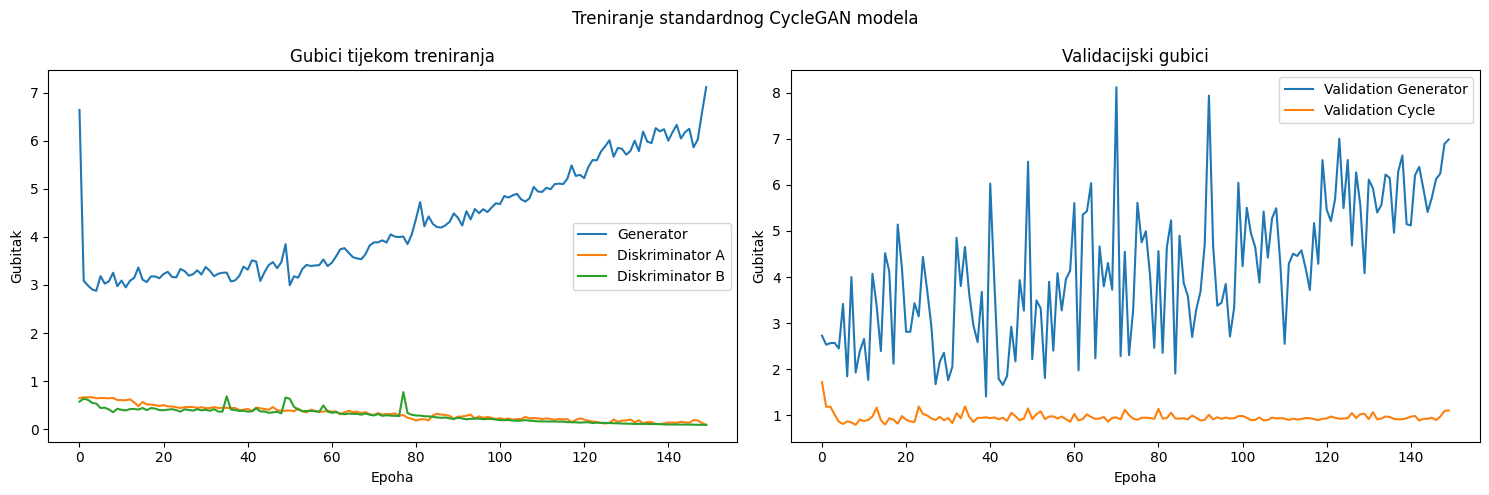

In [8]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [9]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7980
  MSE: 0.006032
  PSNR: 22.64 dB

T2 -> T1 translacija:
  SSIM: 0.7606
  MSE: 0.008472
  PSNR: 20.89 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8311
  MSE: 0.004824
  PSNR: 23.27 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8284
  MSE: 0.005490
  PSNR: 22.77 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6784
  MSE: 0.009963
  PSNR: 20.46 dB

T2 -> T1 translacija:
  SSIM: 0.7093
  MSE: 0.011414
  PSNR: 19.67 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8173
  MSE: 0.005603
  PSNR: 22.70 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7699
  MSE: 0.008818
  PSNR: 20.72 dB


Vizualizacija rezultata na test setu:


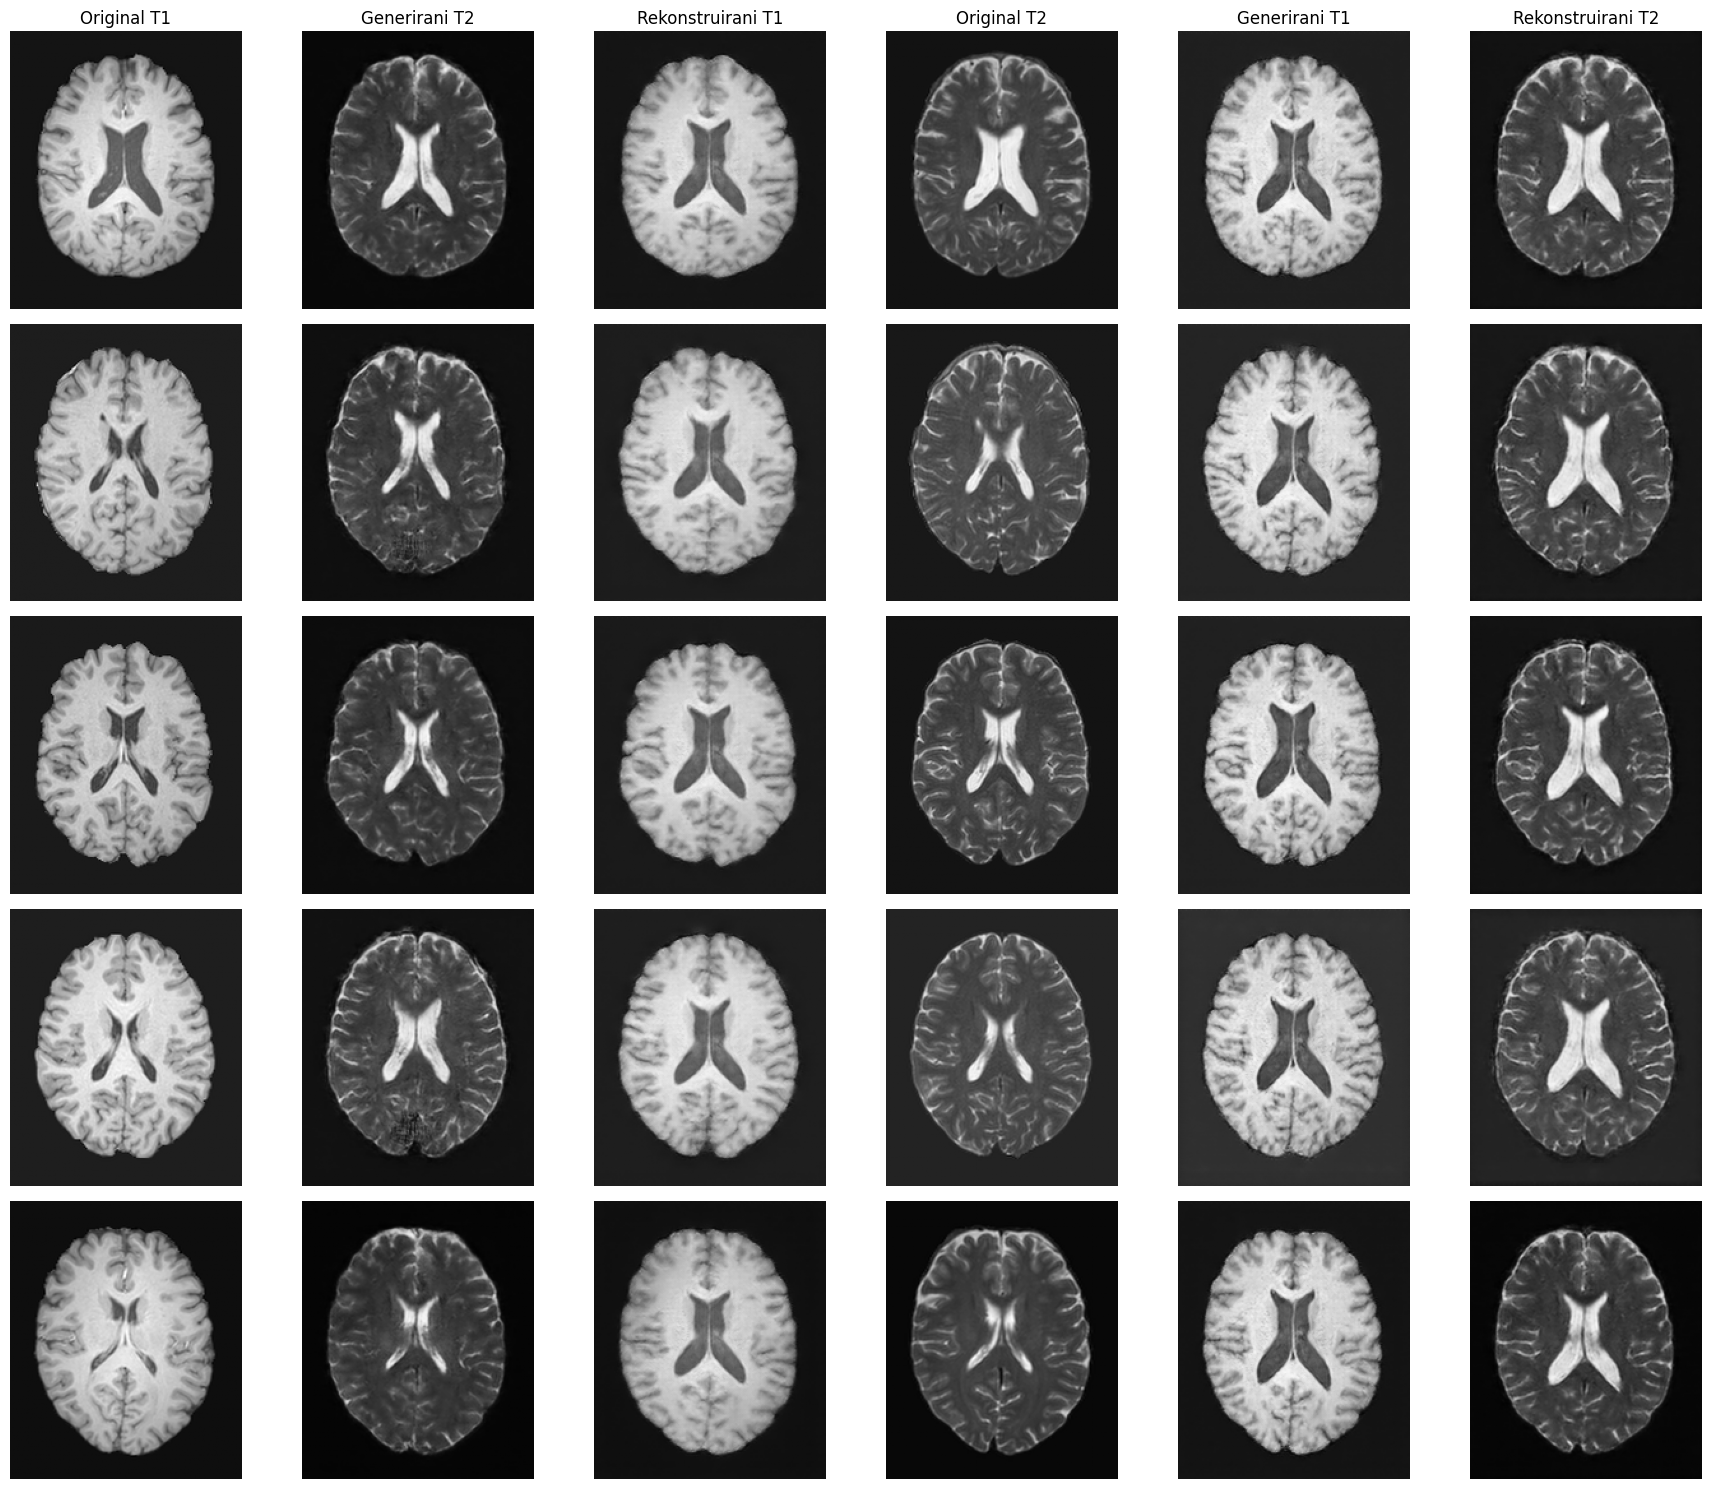

In [10]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=5, config=config)

In [11]:
best_G_AB_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_cycle = f"{config.checkpoints_dir}/G_AB_cycle_best.pth"
best_G_BA_path_cycle = f"{config.checkpoints_dir}/G_BA_cycle_best.pth"
best_G_AB_cycle.load_state_dict(torch.load(best_G_AB_path_cycle, map_location=config.device))
best_G_BA_cycle.load_state_dict(torch.load(best_G_BA_path_cycle, map_location=config.device))

<All keys matched successfully>

In [12]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_cycle, best_G_BA_cycle, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.86it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.6741
  MSE: 0.012322
  PSNR: 19.36 dB

T2 -> T1 translacija:
  SSIM: 0.6505
  MSE: 0.016658
  PSNR: 17.93 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9132
  MSE: 0.001361
  PSNR: 28.77 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8745
  MSE: 0.002442
  PSNR: 26.56 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5000
  MSE: 0.020348
  PSNR: 17.19 dB

T2 -> T1 translacija:
  SSIM: 0.4320
  MSE: 0.027514
  PSNR: 15.75 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8614
  MSE: 0.002247
  PSNR: 26.60 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8187
  MSE: 0.004028
  PSNR: 24.38 dB


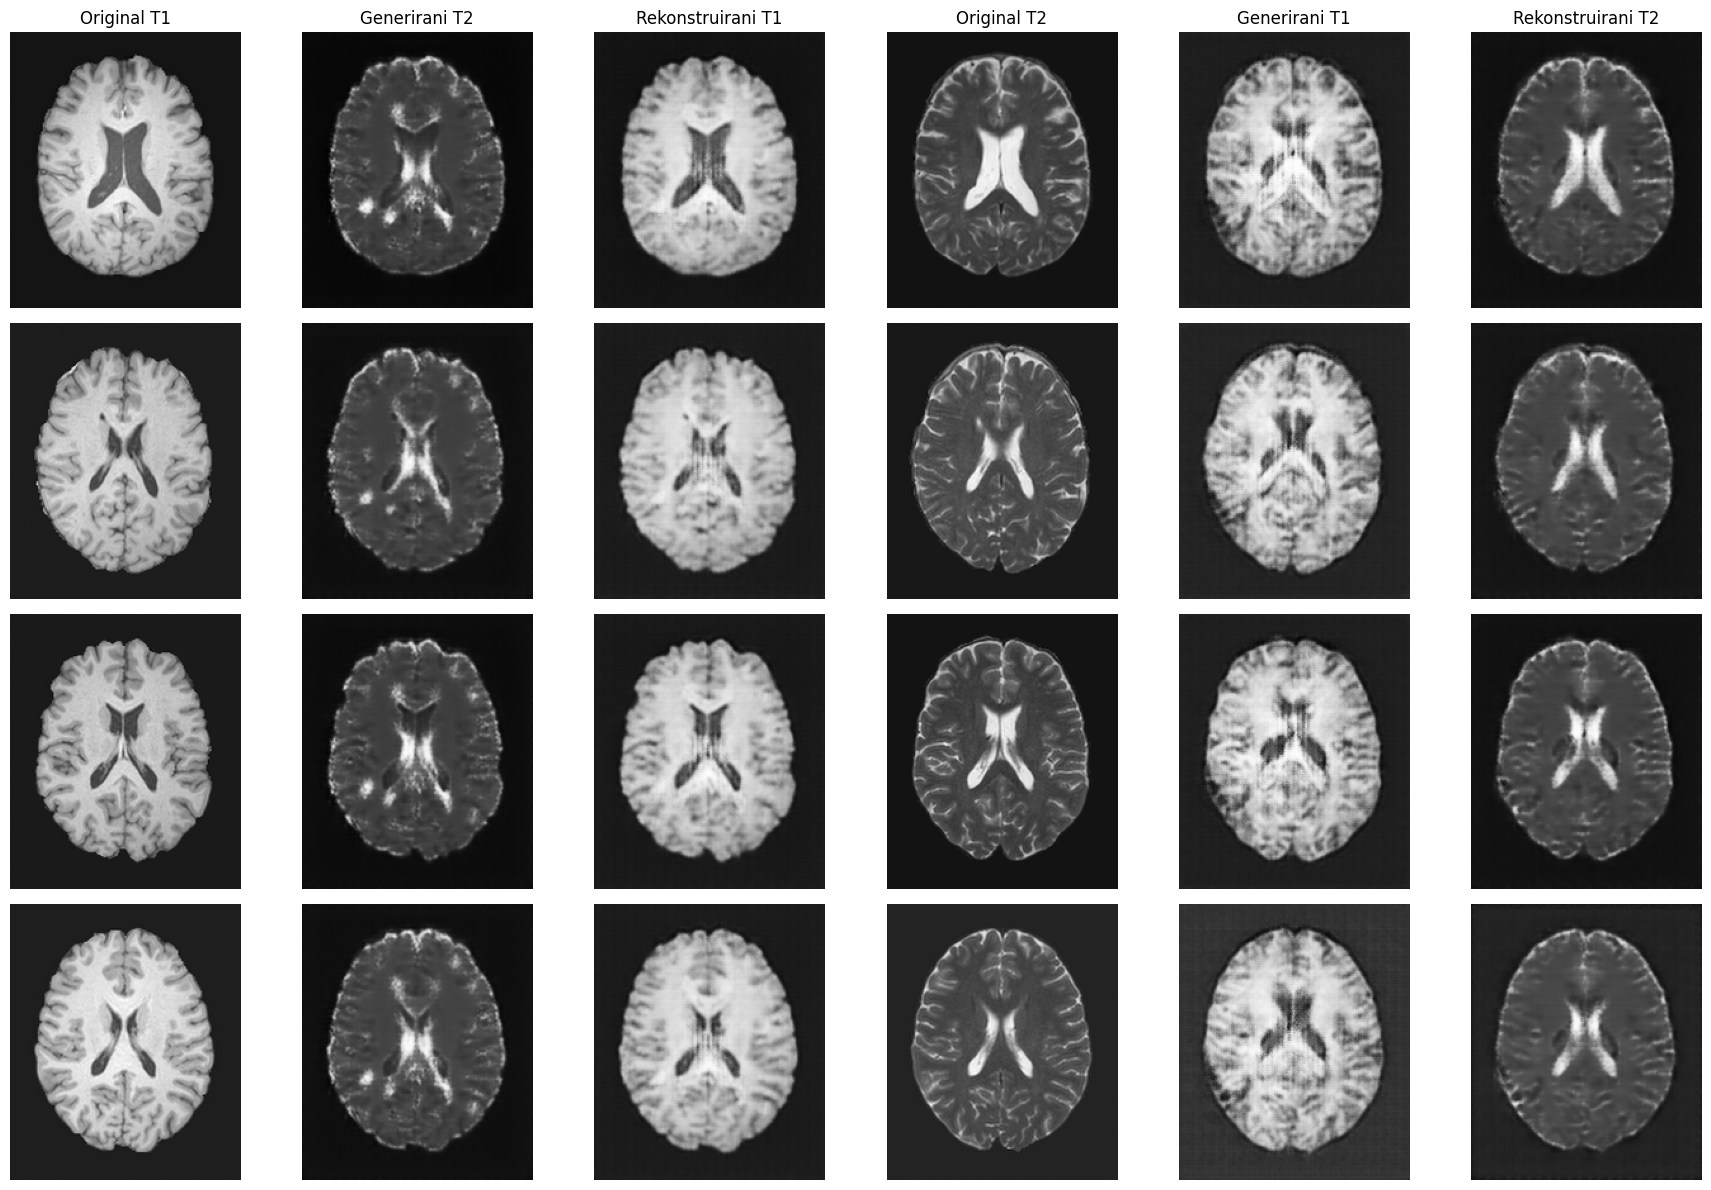

In [13]:
visualize_results(
    best_G_AB_cycle, best_G_BA_cycle, test_dataloader, num_samples=4, config=config
)

In [14]:
best_G_AB_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_gan = f"{config.checkpoints_dir}/G_AB_gan_best.pth"
best_G_BA_path_gan = f"{config.checkpoints_dir}/G_BA_gan_best.pth"
best_G_AB_gan.load_state_dict(torch.load(best_G_AB_path_gan, map_location=config.device))
best_G_BA_gan.load_state_dict(torch.load(best_G_BA_path_gan, map_location=config.device))

<All keys matched successfully>

In [15]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_gan, best_G_BA_gan, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.90it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7494
  MSE: 0.009467
  PSNR: 20.42 dB

T2 -> T1 translacija:
  SSIM: 0.7602
  MSE: 0.008074
  PSNR: 21.04 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8918
  MSE: 0.002829
  PSNR: 25.57 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8598
  MSE: 0.005118
  PSNR: 22.99 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6015
  MSE: 0.015636
  PSNR: 18.24 dB

T2 -> T1 translacija:
  SSIM: 0.6090
  MSE: 0.013336
  PSNR: 18.86 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8221
  MSE: 0.004672
  PSNR: 23.39 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7739
  MSE: 0.008452
  PSNR: 20.81 dB
